In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
markers = ['*','+','.','1']
import pandas as pd
import numpy as np
import scipy.stats as sps
from scipy.stats import multivariate_normal as mvn
import import_ipynb
from IPython.display import Markdown
import DM2 as dm2   # DM2 used is the work of Ed-dahmouni Abdessamad

In [2]:
#Load Data
train = pd.read_csv("data/EMGaussian.data",sep=" ",names=["x","y"])
test  = pd.read_csv("data/EMGaussian.test",sep=" ",names=["x","y"])

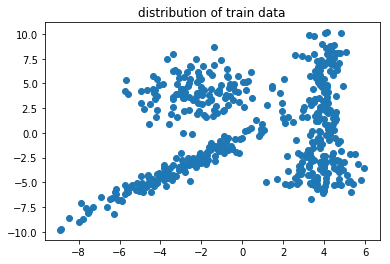

In [3]:
plt.scatter(train['x'], train['y'])
plt.title("distribution of train data")
plt.show()

### Question 1 & 2: Sum Product Algorithm and estimation equations
The answers are implemented in HMM class, Estep provides the estimation equations

In [4]:
class HMM(object):
    def __init__(self,K,A,pi_0,mean,cov,data):
        """
        Args:
            K (int): number of states
            A: transition matrix A(q_prime, q) = p(q|q_prime)
            pi_0: initial distribution of q
            mean: vector of guassian distribution's means
            cov: vector of gaussian distribution's covs
            data: data to be used for HMM
        """
        self.K     = K
        self.A     = A
        self.pi_0  = pi_0
        self.mu    = mean
        self.sigma = cov
        self.data  = data
        self.T     = len(data)
    def emission(self,u):
        """
        Compute p(u|q=i) = N(mu_i, sigma_i)(u)
            u: data observation
            q: latent variable
        """
        return np.array([mvn.pdf(u, self.mu[k], self.sigma[k]) for k in range(self.K)])
    
    def alpha(self):
        """ returns:
                logalpha (T, K)
        """
        logalpha = np.zeros((self.T,self.K))
        logalpha[0] = np.log(self.pi_0) + np.log(self.emission(self.data.iloc[0]))

        for t in range(self.T-1):
            max_logalpha = logalpha[t].max()
            p = np.exp(logalpha[t] - max_logalpha)
            
            logalpha[t+1] = np.log(self.emission(self.data.iloc[t+1])) + np.log(np.dot((self.A).T,p)) + max_logalpha
            
            #np.multiply(self.emission(self.data.iloc[t+1]),np.dot(self.A.T,alpha[t]))
            #alpha[t,1] = sps.norm.pdf(x = data.iloc[t],loc = mu[1],scale = sigma[1])*np.dot(a[1],alpha[t-1])
            #alpha[t,2] = sps.norm.pdf(x = data.iloc[t],loc = mu[2],scale = sigma[2])*np.dot(a[2],alpha[t-1])
            #alpha[t,3] = sps.norm.pdf(x = data.iloc[t],loc = mu[3],scale = sigma[3])*np.dot(a[3],alpha[t-1])
        return logalpha
                                   
    def beta(self):
        """ returns:
                logbeta (K, T)
        """
        logbeta      = np.zeros((self.T,self.K))
                                   
        for t in range(self.T-2,-1,-1):
            max_logbeta = logbeta[t+1].max()
            p = np.exp(logbeta[t+1]-max_logbeta + np.log(self.emission(self.data.iloc[t+1])))
                                  
            logbeta[t] = np.log(np.dot(self.A,p)) + max_logbeta
                                   
            #p.multiply(self.emission(self.data.iloc[t+1]), np.dot(self.A.T,beta[t+1]))
            
        return logbeta
    
    def Estep(self):
        """ Perform Estimation step of EM algorithm 
        """
        logalpha = self.alpha()
        logbeta  = self.beta()
        max_log  = (logalpha + logbeta).max()
        logp_u   = np.log(np.sum(np.exp(logalpha[-1]-max_log))) + max_log       # p(u1,...,uT)
        
        expected_q  = np.exp(logalpha + logbeta - max_log)                 # E[delta(qt=i)|u]
        expected_q /= expected_q.sum(axis=1)[:,None]
        
        log_expected_q1 = np.ones((self.T,self.K,self.K)) 
        
        for t in range(self.T-1):
            log_a_j_b_i = np.add.outer(logbeta[t+1],logalpha[t]) + np.log(self.A.T)
            log_y_q     = np.log(self.emission(self.data.iloc[t+1]))
            log_expected_q1[t] = log_a_j_b_i + np.array([log_y_q]*self.K).T
            log_expected_q1[t]-= log_expected_q1[t].max()
            
        expected_q1 = np.exp(log_expected_q1)
#         expected_q1 /= expected_q1.sum(axis=-1)[...,None]

        return expected_q, expected_q1, logp_u
        

### Question 3 : EM implementation

In [5]:
class EM:
    def __init__(self,K,data):
        """
        Initializes with results from k-means and performs EM on HMM model
        Args:
            K (int): number of states
            data: data to be used for HMM
        """
        
        self.A = np.ones((K,K))/float(K)
        self.iters = 0
        self.old_ll = 0.
        self.new_ll = 0.
        self.K     = K
        
        model = dm2.EM_algorithm(data,K)
        model.fit(tol=1e-6)
        
        self.pi_0  = model.p_j
        self.mu    = np.array(model.centers)
        self.sigma = np.array(model.sigmas)
        self.data  = data
        self.T     = len(data)
        self.q     = None
        self.q1    = None
        self.p_u   = 0.
        
        
    def emission(self,u):
        """
        Compute p(u|q=i) = N(mu_i, sigma_i)(u)
            u: data observation
            q: latent variable
        """
        return np.array([mvn.pdf(u, self.mu[k], self.sigma[k]) for k in range(self.K)])
    
    def Estep(self):
        obj = HMM(self.K,self.A,self.pi_0,self.mu,self.sigma,self.data)
        self.q ,self.q1,self.p_u = obj.Estep()
        
    def Mstep(self):
        self.pi_0 = self.q[0]
        self.A    = (np.sum(self.q1,axis=0)/np.sum(self.q1,axis=(0,1))[None,:]).T
        self.mu   = (np.dot(self.q.T,self.data.values))/(np.sum(self.q,axis=0)[:,None])
        for i in range(self.K):
            delta = self.data.values-self.mu[i]
            self.sigma[i] =  (delta.T@(delta*self.q[:,i][:,None]))/np.sum(self.q[:,i])
    
    def update(self,verbose):
        """
        performs EM for one step
        """          
        self.Estep()
        self.Mstep()
        self.update_ll() 
        if verbose and self.iters%10 == 0 :
            print('Iteration: {:d}, log likelihood: {:.4f}'.format(self.iters+1, self.new_ll))
                     
    def update_ll(self):
        self.old_ll = self.new_ll
        self.new_ll = self.p_u
                     
    def fit(self,tol=1e-6, max_iters=1000,verbose = False):
        """
        performs EM for one step
        Args:
            verbose: verbosity parameter (False by default)
        """    
        if self.iters == 0 :
            self.update(verbose)
            self.iters += 1
        while(np.abs(self.new_ll-self.old_ll)>tol and self.iters<max_iters):
            self.update(verbose)
            self.iters += 1
        if verbose:
            print('Last iteration: {:d}, log likelihood: {:.4f}'.format(self.iters, self.new_ll))
    
    def ll(self, data):
        sp = HMM(self.K,self.A,self.pi_0,self.mu,self.sigma,data)
        p_u = sp.Estep()[2]
        return p_u,p_u/len(data)
    
    
    def likely_states(self, data):
        """ Viterbi algorithm (forward)
        Args:
            data(T, K): training data, K is the feature dimension
        """
        # Initialization
        T = len(data)
        maxProb = np.zeros((T,self.K))
        prev_state = np.zeros((T,self.K))
        maxProb[0] = np.log(self.pi_0) + np.log(self.emission(data.iloc[0]))
        
        for t in range(1,T):
            temp          = maxProb[t-1][:,None] + np.log(self.emission(data.iloc[t]))[None,:] + np.log(self.A.T)
            maxProb[t]    = np.max(temp,axis=0)
            prev_state[t] = np.argmax(temp,axis=0)                   
        
        q = np.zeros(T, dtype=int)
        q[-1] = np.argmax(maxProb[-1])
        for t in range(T-2,-1,-1):
            q[t] = prev_state[t+1,q[t+1]]
        return q
    
    def predict(self, data):
        """ returns:
                Most likely sequence of states (Viterbi algorithm)
        """
        test = data.copy()
        q    = self.likely_states(test)
        test["state"] = q+1
        return test

In [6]:
# Define function for visualization
def format_output(symbol,n,shape,data):
    #for printing vectors and matrices
    L, C = shape
    G = [data] if n==1 else data
    S =r''
    for i in range(n):
        S +=r'$'+symbol+('_'+str(i+1) if n!=1 else '')
        S +=r'=\begin{bmatrix}' if (L!=1 or C!=1) else r'=' 
        M = [G[i]] if L==1 else G[i]
        for l in range(L):
            S += r'{:.2f}'.format(M[l]) if C==1 else (r'{:.2f} '+ r'& {:.2f}'*(C-1)).format(*M[l])
            if(l!= L-1):
                S+=r'\\'
        S +='\end{bmatrix}, \quad $'if (L!=1 or C!=1) else r', \quad $' 
    display(Markdown(S))

In [7]:
# running general EM on the training data
K = 4
model = EM(K,train)
model.fit(tol=1e-6,verbose=True);
format_output(r'\hat\pi',K,(1,1),model.pi_0)
format_output(r'\hat\mu',K,(2,1),model.mu)
format_output(r'\hat\Sigma',K,(2,2),model.sigma)

# cluster predictions on the training and test data
clusters_train = model.predict(train)
clusters_test  = model.predict(test)
clusters_train['type'] = 'train'
clusters_test['type']  = 'test'
for_sns = pd.concat([clusters_train,clusters_test],axis=0)

Iteration: 1, log likelihood: -2334.8774
Iteration: 11, log likelihood: -1905.3884
Last iteration: 17, log likelihood: -1905.3881


$\hat\pi_1=0.00, \quad $$\hat\pi_2=0.00, \quad $$\hat\pi_3=0.00, \quad $$\hat\pi_4=1.00, \quad $

$\hat\mu_1=\begin{bmatrix}-1.98\\4.19\end{bmatrix}, \quad $$\hat\mu_2=\begin{bmatrix}3.99\\3.65\end{bmatrix}, \quad $$\hat\mu_3=\begin{bmatrix}3.79\\-3.98\end{bmatrix}, \quad $$\hat\mu_4=\begin{bmatrix}-2.97\\-3.45\end{bmatrix}, \quad $

$\hat\Sigma_1=\begin{bmatrix}3.16 & 0.25\\0.25 & 2.80\end{bmatrix}, \quad $$\hat\Sigma_2=\begin{bmatrix}0.20 & 0.26\\0.26 & 12.29\end{bmatrix}, \quad $$\hat\Sigma_3=\begin{bmatrix}0.94 & 0.06\\0.06 & 1.54\end{bmatrix}, \quad $$\hat\Sigma_4=\begin{bmatrix}6.78 & 6.55\\6.55 & 6.66\end{bmatrix}, \quad $

### Question 4: Sequence of most likely states

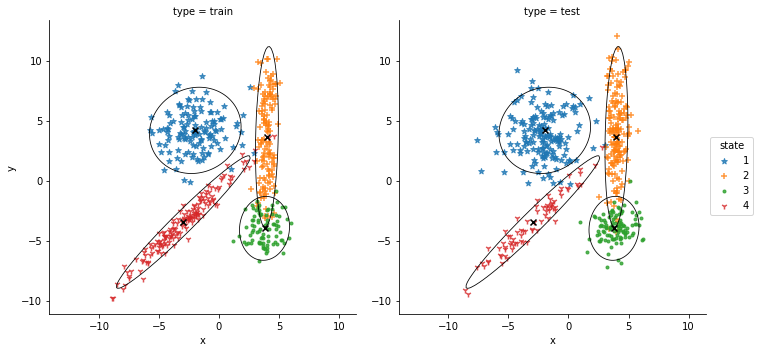

In [8]:
# percentage of distribution inside the ellipse
pct = 0.9
g = sns.lmplot(data=for_sns, x='x', y='y', col='type', hue='state',markers=markers[:K], fit_reg=False)
centers = list(zip(*model.mu))
for ax in g.axes[0]:
    plt.gca().set_aspect('equal')
    ax.scatter(*centers, color='black', marker='x');
    xRange = (for_sns['x'].min(), for_sns['x'].max())
    yRange = (for_sns['y'].min(), for_sns['y'].max())
    x = np.linspace(*xRange, 100)
    y = np.linspace(*yRange, 100)
    x, y = np.meshgrid(x, y)
    for j in range(K):
        Inv = np.linalg.inv(model.sigma[j])
        a, b, c = Inv[0][0], Inv[1][0]+ Inv[0][1], Inv[1][1]
        ax.contour(x, y, a*(x-model.mu[j][0])**2 + b*(x-model.mu[j][0])*(y-model.mu[j][1])+c*(y-model.mu[j][1])**2
                   ,[-2*np.log(1-pct)], colors = 'k', linewidths=0.8)

In [11]:
print(' Normalized log-likelihoods for HMM :')
print('    Training set: {:.3f}'.format(model.ll(train)[1]))
print('    Test set:     {:.3f}'.format(model.ll(test)[1]))

 Normalized log-likelihoods for HMM :
    Training set: -3.811
    Test set:     -3.918
